In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import scanpy as sc
import scipy as sp

import sys 
import os
sys.path.append(os.path.abspath("./utility_functions"))

import rz_functions as rz
import ng_functions as ng
import rz_utility_spring as srz

from time import time
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sns
sns.set_style("whitegrid")


import scrublet as scr

import tox_annotation as tox


/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


python version: 3.6.10


In [2]:
adata = sc.read_h5ad('backups/tox_marie_all_cells_unnormalized_pca_umap_leiden_35358x22631_backup_200604_01h08.h5ad') #coarse + fine + scrublet

adata[:,['Il12b']].X = adata[:,['Il12b', 'eYFP']].X.sum(1)
adata[:,['eYFP']].X = 0


sc.pp.normalize_total(adata, target_sum=1e4)

adata.obs['n_counts'] = adata.X.sum(1).A1

adata.obs['mouse'] = adata.obs.library_name.map(tox.mouse_library_dict).astype('category')
adata.obs.head()


,barcode,group,library_name,marker,max_mt,min_tot,mito_frac,n_counts,n_genes,pool,tissue,treatment,leiden,leiden2,doublet_score,predicted_doublet,mouse
48-pool1,AAACAAACAGAGGATAAGACACCA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.040964,9999.998047,348,pool1,Liver,NT,8,7,0.007103,False,NT1
98-pool1,AAACAAACAGAGGATACAATACTT,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.005613,10000.000000,581,pool1,Liver,NT,20,32,0.014590,False,NT1
237-pool1,AAACAAACAGAGGATAGGCCCTTA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.035451,9999.998047,470,pool1,Liver,NT,11,14,0.016036,False,NT1
246-pool1,AAACAAACAGAGGATAGGGAGGTA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.018000,10000.000000,374,pool1,Liver,NT,Mono12,24,0.027342,False,NT1
342-pool1,AAACAAACAGAGGATATGGCTACC,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.035088,10000.000000,318,pool1,Liver,NT,T17,17,0.007778,False,NT1


In [3]:
#loglikelihoods = sp.sparse.load_npz('backups/loglikelihoods_bay_classif_tox_marie_all_cells_200407_11h02.npz')
logls = np.load('backups/loglikelihoods_bay_classif_tox_marie_all_cells_200407_11h02.npz', allow_pickle=True)

mostlikely_subset = pd.DataFrame(logls['data'], index=logls['index'], columns=logls['columns']).idxmax()
mostlikely_subset = pd.Series(mostlikely_subset, dtype='category')
mostlikely_subset.index = adata.obs.index

mostlikely_celltype = mostlikely_subset.map(ng.cell_subset_dict).astype('category')

In [4]:
adata.obs['cell_type'] = mostlikely_celltype
adata.obs['minor_subset'] = mostlikely_subset

#annotate color palette in adata.uns
adata.uns['cell_type_colors'] = adata.obs['cell_type'].cat.categories.map(ng.cell_type_cmap).tolist()
adata.uns['minor_subset_colors'] = adata.obs['minor_subset'].cat.categories.map(ng.cell_subset_cmap).tolist()

In [5]:
adata = adata[~(adata.obs.predicted_doublet)]
adata = adata[~adata.obs['leiden'].isin(['16', '28','29','30'])]

adata.obs['leiden_minor_subset'] = adata.obs.leiden.map(tox.cluster_annotation_dict).astype('category')
adata.obs['leiden_cell_type'] = adata.obs.leiden_minor_subset.map(tox.coarse_annotation_dict).astype('category')


Trying to set attribute `.obs` of view, copying.


## Reference sets of libraries and clusters

In [128]:
il12b_types = ['DC_CCR7+_CXCL9-', 'DC_CD83_lo', 'DC_Trx2', 'DC_Trx1', 'DC_S100A9+', 'KClike_MARCO-', 'KClike_MARCO+']
il12b_dc = ['DC_CCR7+_CXCL9-', 'DC_CD83_lo', 'DC_Trx2', 'DC_Trx1', 'DC_S100A9+']
il12b_kc = ['KClike_MARCO-', 'KClike_MARCO+']
nt_dc = ['DC1', 'MoDC2']

liver_il12b_trx_libraries = ['Liver_IL12_Trx_I_rep1', 'Liver_IL12_Trx_I_rep2', 'Liver_IL12_Trx_J_rep1', 'Liver_IL12_Trx_J_rep2']
liver_cd45_trx3_libraries = ['Liver_CD45pos_Trx_H','Liver_CD45pos_Trx_G', 'Liver_CD45pos_Trx_F', 'Liver_CD45pos_Trx_E']

Trying to set attribute `.uns` of view, copying.


[<Figure size 600x400 with 1 Axes>]

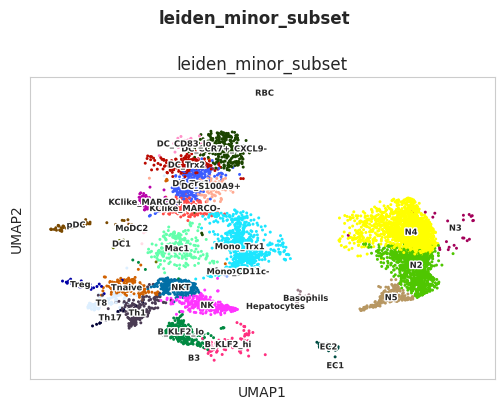

In [7]:
ng.umap_plot(adata, filt="mouse == 'Trx1'", color='leiden_minor_subset')

In [8]:
def multiindex_pivot(df, columns=None, values=None):
    #https://github.com/pandas-dev/pandas/issues/23955
    names = list(df.index.names)
    df = df.reset_index()
    list_index = df[names].values
    tuples_index = [tuple(i) for i in list_index] # hashable
    df = df.assign(tuples_index=tuples_index)
    df = df.pivot(index="tuples_index", columns=columns, values=values)
    tuples_index = df.index  # reduced
    index = pd.MultiIndex.from_tuples(tuples_index, names=names)
    df.index = index
    return df

In [9]:
regex_toavoid = r'(mt-.*|Rps.*|Rpl.*|Mrpl.*|Mrps.*)'

# Dendritic/KClike clusters

## Filter for IL12b+ treated DCs from the IL12b+ liver treated libraries // Add log values for gene variability analysis downstream

In [10]:
il12dcdata = adata[adata.obs.leiden_minor_subset.isin(il12b_dc) & adata.obs.library_name.isin(liver_il12b_trx_libraries)]
il12dcdata.obs.mouse = il12dcdata.obs.mouse.astype('category')
sc.pp.log1p(il12dcdata)

il12kcdata = adata[adata.obs.leiden_minor_subset.isin(il12b_kc) & adata.obs.library_name.isin(liver_il12b_trx_libraries)]
il12kcdata.obs.mouse = il12kcdata.obs.mouse.astype('category')
sc.pp.log1p(il12kcdata)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


## Split data by mouse (Trx1 / Trx3)

In [11]:
il12dcdata1 = il12dcdata[il12dcdata.obs.mouse == 'Trx1']
il12dcdata3 = il12dcdata[il12dcdata.obs.mouse == 'Trx3']

il12kcdata1 = il12kcdata[il12kcdata.obs.mouse == 'Trx1']
il12kcdata3 = il12kcdata[il12kcdata.obs.mouse == 'Trx3']

In [12]:
# Fano sort

# il12dcdata1_X = np.array(il12dcdata1.X.todense())
# il12dcdata3_X = np.array(il12dcdata3.X.todense())

# fanosort_dc1 = np.argsort(np.var(il12dcdata1_X, axis=0)/np.mean(il12dcdata1_X, axis=0))
# fanosort_dc3 = np.argsort(np.var(il12dcdata3_X, axis=0)/np.mean(il12dcdata3_X, axis=0))

# hvdc_trx1 = il12dcdata1.var_names[fanosort_dc1]
# hvdc_trx3 = il12dcdata3.var_names[fanosort_dc3]


#genes_toavoid_dc1 = il12dcdata1.var_names[fanosort_dc1].str.match(regex_toavoid)

In [13]:
hvdc_trx1 = pd.DataFrame(sc.pp.highly_variable_genes(il12dcdata1, n_top_genes=50, inplace=False)).merge(pd.Series(il12dcdata1.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False).gene_name
hvdc_trx3 = pd.DataFrame(sc.pp.highly_variable_genes(il12dcdata3, n_top_genes=50, inplace=False)).merge(pd.Series(il12dcdata3.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False).gene_name

hvkc_trx1 = pd.DataFrame(sc.pp.highly_variable_genes(il12kcdata1, n_top_genes=50, inplace=False)).merge(pd.Series(il12kcdata1.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False).gene_name
hvkc_trx3 = pd.DataFrame(sc.pp.highly_variable_genes(il12kcdata3, n_top_genes=50, inplace=False)).merge(pd.Series(il12kcdata3.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False).gene_name

In [14]:
hvdc_trx1 = hvdc_trx1[~hvdc_trx1.str.match(regex_toavoid)]
hvdc_trx3 = hvdc_trx3[~hvdc_trx3.str.match(regex_toavoid)]

hvkc_trx1 = hvkc_trx1[~hvkc_trx1.str.match(regex_toavoid)]
hvkc_trx3 = hvkc_trx3[~hvkc_trx3.str.match(regex_toavoid)]

In [15]:
len_genes_in_common_dc = []
len_genes_in_common_kc = []

for i in range(500):
    in_common_dc = set(hvdc_trx1[:i]) & set(hvdc_trx3[:i])
    in_common_kc = set(hvkc_trx1[:i]) & set(hvkc_trx3[:i])
    
    len_genes_in_common_dc.append(len(in_common_dc))
    len_genes_in_common_kc.append(len(in_common_kc))

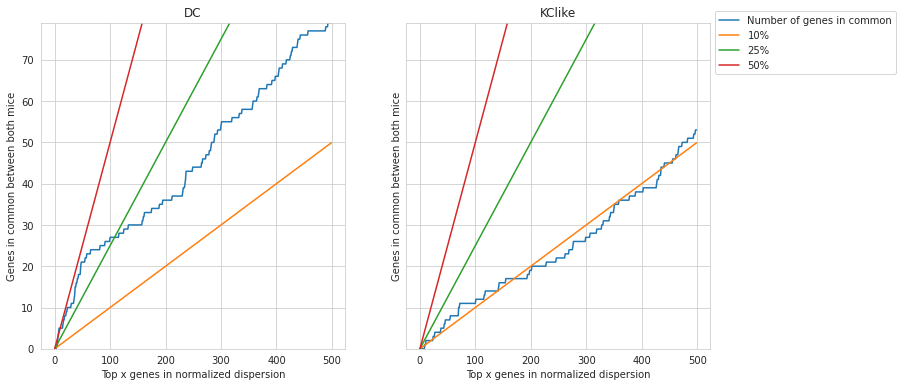

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

axes[0].plot(len_genes_in_common_dc, label='Number of genes in common')
axes[1].plot(len_genes_in_common_kc, label='Number of genes in common')


for ax in axes:
    ax.plot(0.10*np.arange(0,500,1), label='10%')
    ax.plot(0.25*np.arange(0,500,1), label='25%')
    ax.plot(0.50*np.arange(0,500,1), label='50%')
    ax.set_ylabel('Genes in common between both mice')
    ax.set_xlabel('Top x genes in normalized dispersion')
    
axes[0].set_ylim(0,len_genes_in_common_dc[-1])
#axes[1].set_ylim(0,len_genes_in_common_kc[-1])

axes[0].set_title('DC')
axes[1].set_title('KClike')

axes[1].legend(bbox_to_anchor=(1,1.05))
plt.show()

## Compute the 25 most variable genes that are highly variable in both mice

In [17]:
hvdc_genes_consensus = set(hvdc_trx1[:90]) & set(hvdc_trx3[:90])
hvkc_genes_consensus = set(hvkc_trx1[:290]) & set(hvkc_trx3[:290])

In [18]:
print(len(hvdc_genes_consensus))
print(len(hvkc_genes_consensus))

25
26


In [19]:
hvdcdata = il12dcdata[:,il12dcdata.var_names.isin(hvdc_genes_consensus)]
hvdcx = pd.DataFrame(hvdcdata.X.todense(), columns=hvdcdata.var.index, index=hvdcdata.obs.index)
hvdcdf = hvdcdata.obs.loc[:,['mouse']].merge(hvdcx, left_index=True, right_index=True)

hvkcdata = il12kcdata[:,il12kcdata.var_names.isin(hvkc_genes_consensus)]
hvkcx = pd.DataFrame(hvkcdata.X.todense(), columns=hvkcdata.var.index, index=hvkcdata.obs.index)
hvkcdf = hvkcdata.obs.loc[:,['mouse']].merge(hvkcx, left_index=True, right_index=True)

In [20]:
hvdccov = hvdcdf.groupby(['mouse']).cov()
hvdccov = hvdccov.reset_index().melt(id_vars=['mouse', 'level_1'])

hvdccorr = hvdcdf.groupby(['mouse']).corr()
hvdccorr = hvdccorr.reset_index().melt(id_vars=['mouse', 'level_1'])

hvkccov = hvkcdf.groupby(['mouse']).cov()
hvkccov = hvkccov.reset_index().melt(id_vars=['mouse', 'level_1'])

hvkccorr = hvkcdf.groupby(['mouse']).corr()
hvkccorr = hvkccorr.reset_index().melt(id_vars=['mouse', 'level_1'])

In [195]:
hvdccov_scatter = multiindex_pivot(hvdccov.set_index(['variable','level_1']), columns='mouse', values='value') 
hvdccov_scatter = hvdccov_scatter.rename(columns=str).reset_index()

hvdccorr_scatter = multiindex_pivot(hvdccorr.set_index(['variable','level_1']), columns='mouse', values='value') 
hvdccorr_scatter = hvdccorr_scatter.rename(columns=str).reset_index()

hvdccorr_scatter = hvdccov_scatter[hvdccov_scatter.variable != hvdccov_scatter.level_1]
hvdccorr_scatter = hvdccorr_scatter[hvdccorr_scatter.variable != hvdccorr_scatter.level_1]

hvkccov_scatter = multiindex_pivot(hvkccov.set_index(['variable','level_1']), columns='mouse', values='value') 
hvkccov_scatter = hvkccov_scatter.rename(columns=str).reset_index()

hvkccorr_scatter = multiindex_pivot(hvkccorr.set_index(['variable','level_1']), columns='mouse', values='value') 
hvkccorr_scatter = hvkccorr_scatter.rename(columns=str).reset_index()

hvkccov_scatter = hvkccov_scatter[hvkccov_scatter.variable != hvkccov_scatter.level_1]
hvkccorr_scatter = hvkccorr_scatter[hvkccorr_scatter.variable != hvkccorr_scatter.level_1]

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


[<Figure size 600x400 with 1 Axes>, <Figure size 600x400 with 1 Axes>]

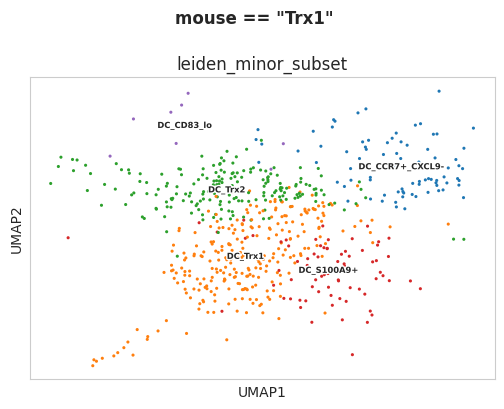

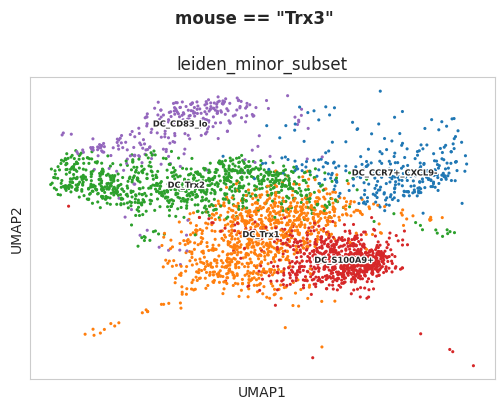

In [22]:
ng.umap_plot(il12dcdata, split_by_cats = 'mouse', color = 'leiden_minor_subset', size=20)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


[<Figure size 600x400 with 1 Axes>, <Figure size 600x400 with 1 Axes>]

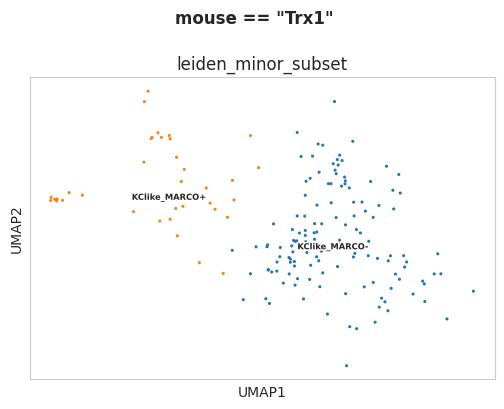

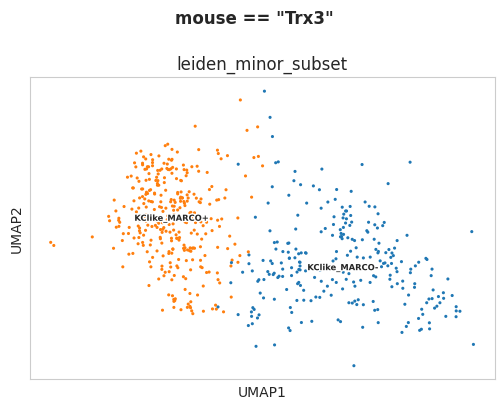

In [23]:
ng.umap_plot(il12kcdata, split_by_cats = 'mouse', color = 'leiden_minor_subset', size=20)

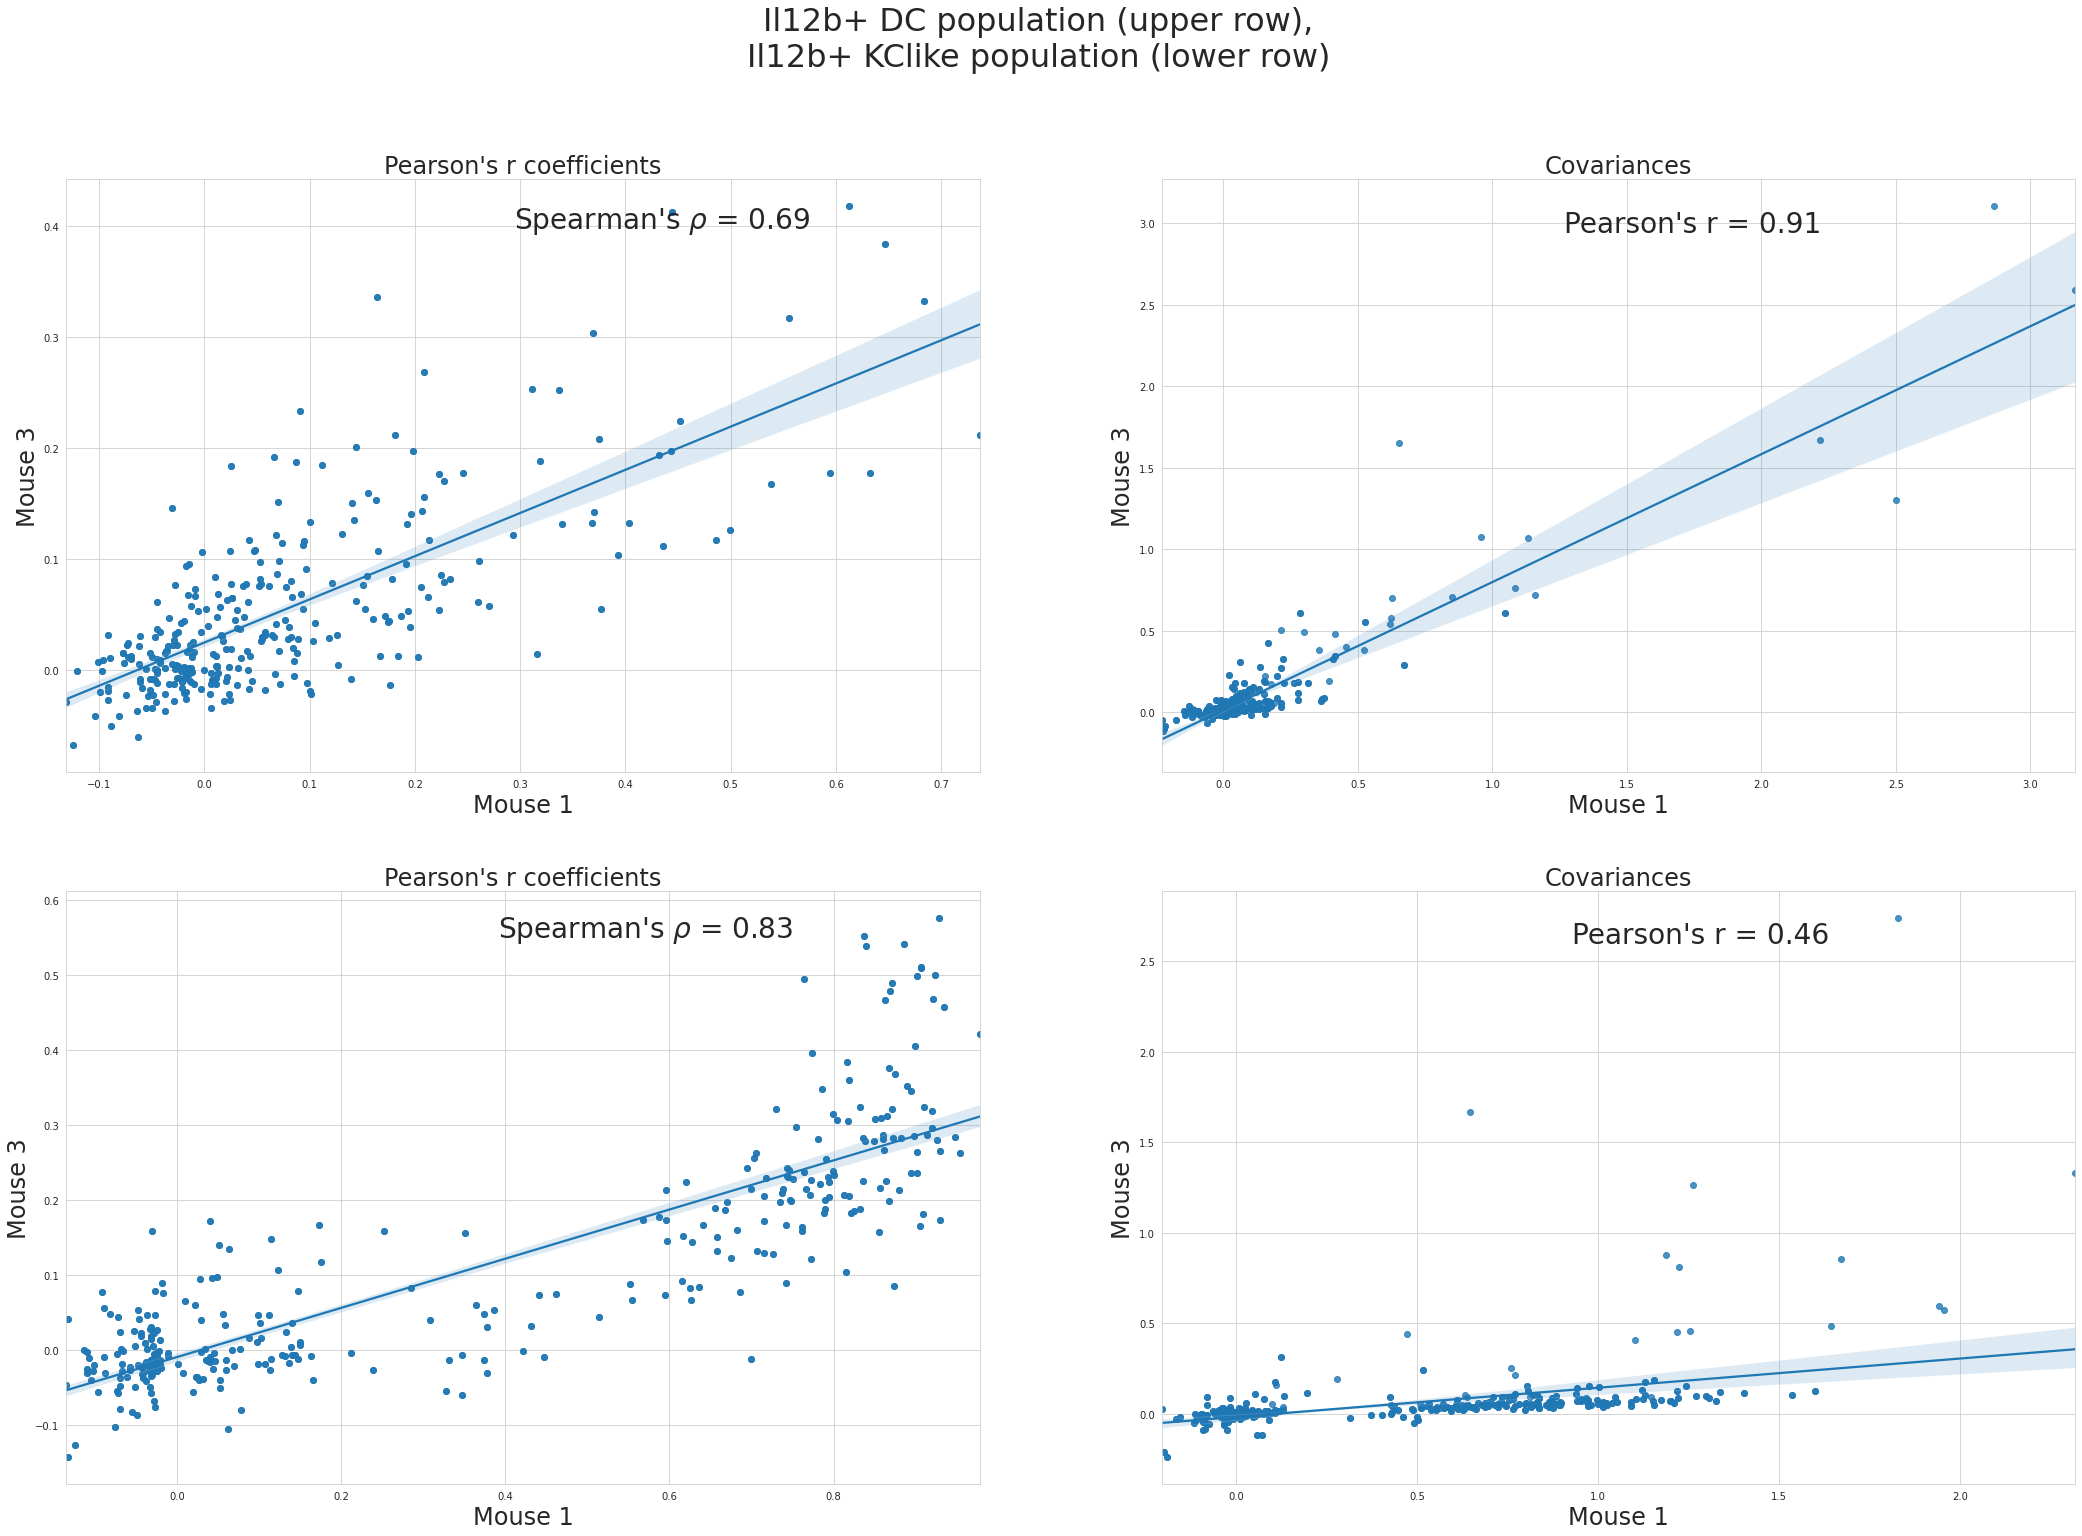

In [24]:
fig, axes = plt.subplots(2,2, figsize=(36,24))

corr_correl = round(hvdccorr_scatter.corr(method='spearman').iloc[0,1],2)
cov_correl = round(hvdccov_scatter.corr().iloc[0,1],2)

corr_plot = sns.regplot(data=hvdccorr_scatter, x='Trx1', y='Trx3', ax=axes[0,0], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (0.4*axes[0,0].get_xlim()[1],0.9*axes[0,0].get_ylim()[1]), fontsize=28)
axes[0,0].set_title("Pearson's r coefficients", fontsize=24)

cov_plot = sns.regplot(data=hvdccov_scatter, x='Trx1', y='Trx3', ax=axes[0,1], robust=False)
cov_plot.annotate(r"Pearson's r = {}".format(cov_correl), (0.4*axes[0,1].get_xlim()[1],0.9*axes[0,1].get_ylim()[1]), fontsize=28)
axes[0,1].set_title("Covariances", fontsize= 24)

corr_correl = round(hvkccorr_scatter.corr(method='spearman').iloc[0,1],2)
cov_correl = round(hvkccov_scatter.corr().iloc[0,1],2)

corr_plot = sns.regplot(data=hvkccorr_scatter, x='Trx1', y='Trx3', ax=axes[1,0], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (0.4*axes[1,0].get_xlim()[1],0.9*axes[1,0].get_ylim()[1]), fontsize=28)
axes[1,0].set_title("Pearson's r coefficients", fontsize=24)

cov_plot = sns.regplot(data=hvkccov_scatter, x='Trx1', y='Trx3', ax=axes[1,1], robust=False)
cov_plot.annotate(r"Pearson's r = {}".format(cov_correl), (0.4*axes[1,1].get_xlim()[1],0.9*axes[1,1].get_ylim()[1]), fontsize=28)
axes[1,1].set_title("Covariances", fontsize= 24)

plt.suptitle('Il12b+ DC population (upper row),\nIl12b+ KClike population (lower row)', fontsize=32)

for ax in axes.ravel():
    ax.set_xlabel('Mouse 1', fontsize=24)
    ax.set_ylabel('Mouse 3', fontsize=24)

plt.show()

# Negative control: subset data from mouse Trx3

In [25]:
dc_trx3_subset_indices = np.array(int(il12dcdata3.shape[0] / 2)*[True, False])

np.random.seed(111)
np.random.shuffle(dc_trx3_subset_indices)

il12dcdata3_1 = il12dcdata3[dc_trx3_subset_indices]
il12dcdata3_2 = il12dcdata3[~dc_trx3_subset_indices]

il12dcdata3.obs['mouse_subset'] = (-1*dc_trx3_subset_indices+2).astype('str')

Trying to set attribute `.obs` of view, copying.


In [26]:
# Fano sort

# il12dcdata1_X = np.array(il12dcdata1.X.todense())
# il12dcdata3_X = np.array(il12dcdata3.X.todense())

# fanosort_dc1 = np.argsort(np.var(il12dcdata1_X, axis=0)/np.mean(il12dcdata1_X, axis=0))
# fanosort_dc3 = np.argsort(np.var(il12dcdata3_X, axis=0)/np.mean(il12dcdata3_X, axis=0))

# hvdc_trx1 = il12dcdata1.var_names[fanosort_dc1]
# hvdc_trx3 = il12dcdata3.var_names[fanosort_dc3]


#genes_toavoid_dc1 = il12dcdata1.var_names[fanosort_dc1].str.match(regex_toavoid)

In [51]:
hvdc_trx3_1 = pd.DataFrame(sc.pp.highly_variable_genes(il12dcdata3_1, n_top_genes=50, inplace=False)).merge(pd.Series(il12dcdata3_1.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False).gene_name
hvdc_trx3_2 = pd.DataFrame(sc.pp.highly_variable_genes(il12dcdata3_2, n_top_genes=50, inplace=False)).merge(pd.Series(il12dcdata3_2.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False).gene_name

hvdc_trx3_1 = hvdc_trx3_1[~hvdc_trx3_1.str.match(regex_toavoid)]
hvdc_trx3_2 = hvdc_trx3_2[~hvdc_trx3_2.str.match(regex_toavoid)]

# hvdc_trx1 = pd.DataFrame(sc.pp.highly_variable_genes(il12dcdata1, n_top_genes=50, inplace=False)).merge(pd.Series(il12dcdata1.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False).gene_name
# hvdc_trx3 = pd.DataFrame(sc.pp.highly_variable_genes(il12dcdata3, n_top_genes=50, inplace=False)).merge(pd.Series(il12dcdata3.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False).gene_name

# hvkc_trx1 = pd.DataFrame(sc.pp.highly_variable_genes(il12kcdata1, n_top_genes=50, inplace=False)).merge(pd.Series(il12kcdata1.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False).gene_name
# hvkc_trx3 = pd.DataFrame(sc.pp.highly_variable_genes(il12kcdata3, n_top_genes=50, inplace=False)).merge(pd.Series(il12kcdata3.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False).gene_name

In [52]:
len_genes_in_common_31_vs_32 = []

for i in range(500):
    in_common_31_vs_32 = set(hvdc_trx3_1[:i]) & set(hvdc_trx3_2[:i])
    
    len_genes_in_common_31_vs_32.append(len(in_common_31_vs_32))

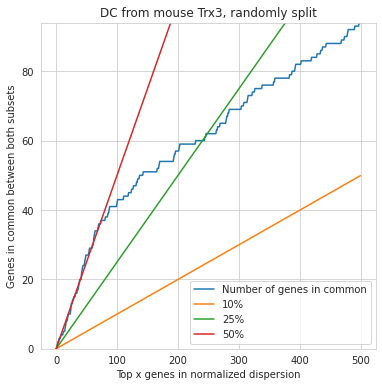

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.plot(len_genes_in_common_31_vs_32, label='Number of genes in common')
#axes[1].plot(len_genes_in_common_kc, label='Number of genes in common')


ax.plot(0.10*np.arange(0,500,1), label='10%')
ax.plot(0.25*np.arange(0,500,1), label='25%')
ax.plot(0.50*np.arange(0,500,1), label='50%')
ax.set_ylabel('Genes in common between both subsets')
ax.set_xlabel('Top x genes in normalized dispersion')
    
ax.set_ylim(0,len_genes_in_common_31_vs_32[-1])
#axes[1].set_ylim(0,len_genes_in_common_kc[-1])

ax.set_title('DC from mouse Trx3, randomly split')
#axes[1].set_title('KClike')

plt.legend()
#axes[1].legend(bbox_to_anchor=(1,1.05))
plt.show()

In [60]:
hvdc_31_vs_32_consensus = set(hvdc_trx3_1[:47]) & set(hvdc_trx3_2[:47])

In [61]:
print(len(hvdc_31_vs_32_consensus))
#print(len(hvkc_genes_consensus))

25


In [62]:
hvdcdata3 = il12dcdata3[:,il12dcdata3.var_names.isin(hvdc_31_vs_32_consensus)]
hvdcx3 = pd.DataFrame(hvdcdata3.X.todense(), columns=hvdcdata3.var.index, index=hvdcdata3.obs.index)
hvdcdf3 = hvdcdata3.obs.loc[:,['mouse_subset']].merge(hvdcx3, left_index=True, right_index=True)

In [63]:
hvdccov3 = hvdcdf3.groupby(['mouse_subset']).cov()
hvdccov3 = hvdccov3.reset_index().melt(id_vars=['mouse_subset', 'level_1'])

hvdccorr3 = hvdcdf3.groupby(['mouse_subset']).corr()
hvdccorr3 = hvdccorr3.reset_index().melt(id_vars=['mouse_subset', 'level_1'])

In [160]:
hvdccov3_scatter = multiindex_pivot(hvdccov3.set_index(['variable','level_1']), columns='mouse_subset', values='value') 
hvdccov3_scatter = hvdccov3_scatter.rename(columns=str).reset_index()

hvdccorr3_scatter = multiindex_pivot(hvdccorr3.set_index(['variable','level_1']), columns='mouse_subset', values='value') 
hvdccorr3_scatter = hvdccorr3_scatter.rename(columns=str).reset_index()

hvdccorr3_scatter = hvdccov3_scatter[hvdccov3_scatter.variable != hvdccov3_scatter.level_1]
hvdccorr3_scatter = hvdccorr3_scatter[hvdccorr3_scatter.variable != hvdccorr3_scatter.level_1]

# Negative control

In [138]:
il12ncdata = adata[(adata.obs.leiden_minor_subset.isin(il12b_dc) & adata.obs.library_name.isin(liver_il12b_trx_libraries) & adata.obs.mouse.isin(['Trx3'])) |\
 (adata.obs.leiden_minor_subset.isin(nt_dc) & adata.obs.library_name.isin(liver_cd45_trx3_libraries))]

sc.pp.log1p(il12ncdata)

il12ncdata.obs['control_subset'] = (~il12ncdata.obs.leiden_minor_subset.isin(il12b_dc)).map({True : 'Mono', False : 'DC'})


/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [48]:
il12ncdata = adata[adata.obs.leiden_minor_subset.isin(il12b_dc) | (adata.obs.leiden_minor_subset == 'Mono_Trx1') & adata.obs.library_name.isin(liver_il12b_trx_libraries) & adata.obs.mouse.isin(['Trx3'])]
sc.pp.log1p(il12ncdata)
il12ncdata.obs['control_subset'] = (il12ncdata.obs.leiden_minor_subset == 'Mono_Trx1').map({True : 'Mono', False : 'DC'})

In [139]:
il12ncdata_dc = il12ncdata[il12ncdata.obs.control_subset == 'DC']
il12ncdata_mono = il12ncdata[il12ncdata.obs.control_subset == 'Mono']


In [140]:
hvnc_dc = pd.DataFrame(sc.pp.highly_variable_genes(il12ncdata_dc, n_top_genes=50, inplace=False)).merge(pd.Series(il12ncdata_dc.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False).gene_name
hvnc_mono = pd.DataFrame(sc.pp.highly_variable_genes(il12ncdata_mono, n_top_genes=50, inplace=False)).merge(pd.Series(il12ncdata_mono.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False).gene_name

hvnc_dc = hvnc_dc[~hvnc_dc.str.match(regex_toavoid)]
hvnc_mono = hvnc_mono[~hvnc_mono.str.match(regex_toavoid)]


/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/scanpy/preprocessing/_highly_variable_genes.py:89: RuntimeWarning: divide by zero encountered in true_divide
  ) / disp_std_bin[df['mean_bin'].values].values


In [141]:
len_genes_in_common_nc = []

for i in range(500):
    in_common_nc = set(hvnc_dc[:i]) & set(hvnc_mono[:i])
    
    len_genes_in_common_nc.append(len(in_common_nc))

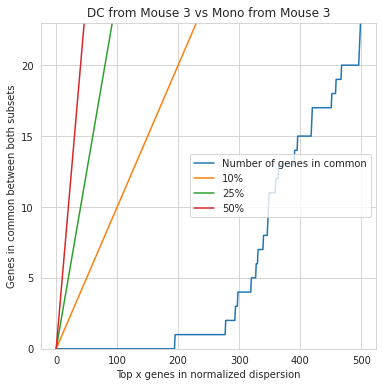

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.plot(len_genes_in_common_nc, label='Number of genes in common')
#axes[1].plot(len_genes_in_common_kc, label='Number of genes in common')


ax.plot(0.10*np.arange(0,500,1), label='10%')
ax.plot(0.25*np.arange(0,500,1), label='25%')
ax.plot(0.50*np.arange(0,500,1), label='50%')
ax.set_ylabel('Genes in common between both subsets')
ax.set_xlabel('Top x genes in normalized dispersion')
    
ax.set_ylim(0,len_genes_in_common_nc[-1])
#axes[1].set_ylim(0,len_genes_in_common_kc[-1])

ax.set_title('DC from Mouse 3 vs Mono from Mouse 3')
#axes[1].set_title('KClike')

plt.legend()
#axes[1].legend(bbox_to_anchor=(1,1.05))
plt.show()

In [146]:
hvnc_consensus = set(hvnc_dc[:500]) & set(hvnc_mono[:500])

In [147]:
len(hvnc_consensus)

23

In [148]:
hvncdata = il12ncdata[:,il12ncdata.var_names.isin(hvnc_consensus)]
hvncx = pd.DataFrame(hvncdata.X.todense(), columns=hvncdata.var.index, index=hvncdata.obs.index)
hvncdf = hvncdata.obs.loc[:,['control_subset']].merge(hvncx, left_index=True, right_index=True)

In [149]:
hvnccov = hvncdf.groupby(['control_subset']).cov()
hvnccov = hvnccov.reset_index().melt(id_vars=['control_subset', 'level_1'])

hvnccorr = hvncdf.groupby(['control_subset']).corr()
hvnccorr = hvnccorr.reset_index().melt(id_vars=['control_subset', 'level_1'])

In [157]:
hvnccov_scatter = multiindex_pivot(hvnccov.set_index(['variable','level_1']), columns='control_subset', values='value') 
hvnccov_scatter = hvnccov_scatter.rename(columns=str).reset_index()

hvnccorr_scatter = multiindex_pivot(hvnccorr.set_index(['variable','level_1']), columns='control_subset', values='value') 
hvnccorr_scatter = hvnccorr_scatter.rename(columns=str).reset_index()

hvnccov_scatter = hvnccov_scatter[hvnccov_scatter.variable != hvnccov_scatter.level_1]
hvnccorr_scatter = hvnccorr_scatter[hvnccorr_scatter.variable != hvnccorr_scatter.level_1]

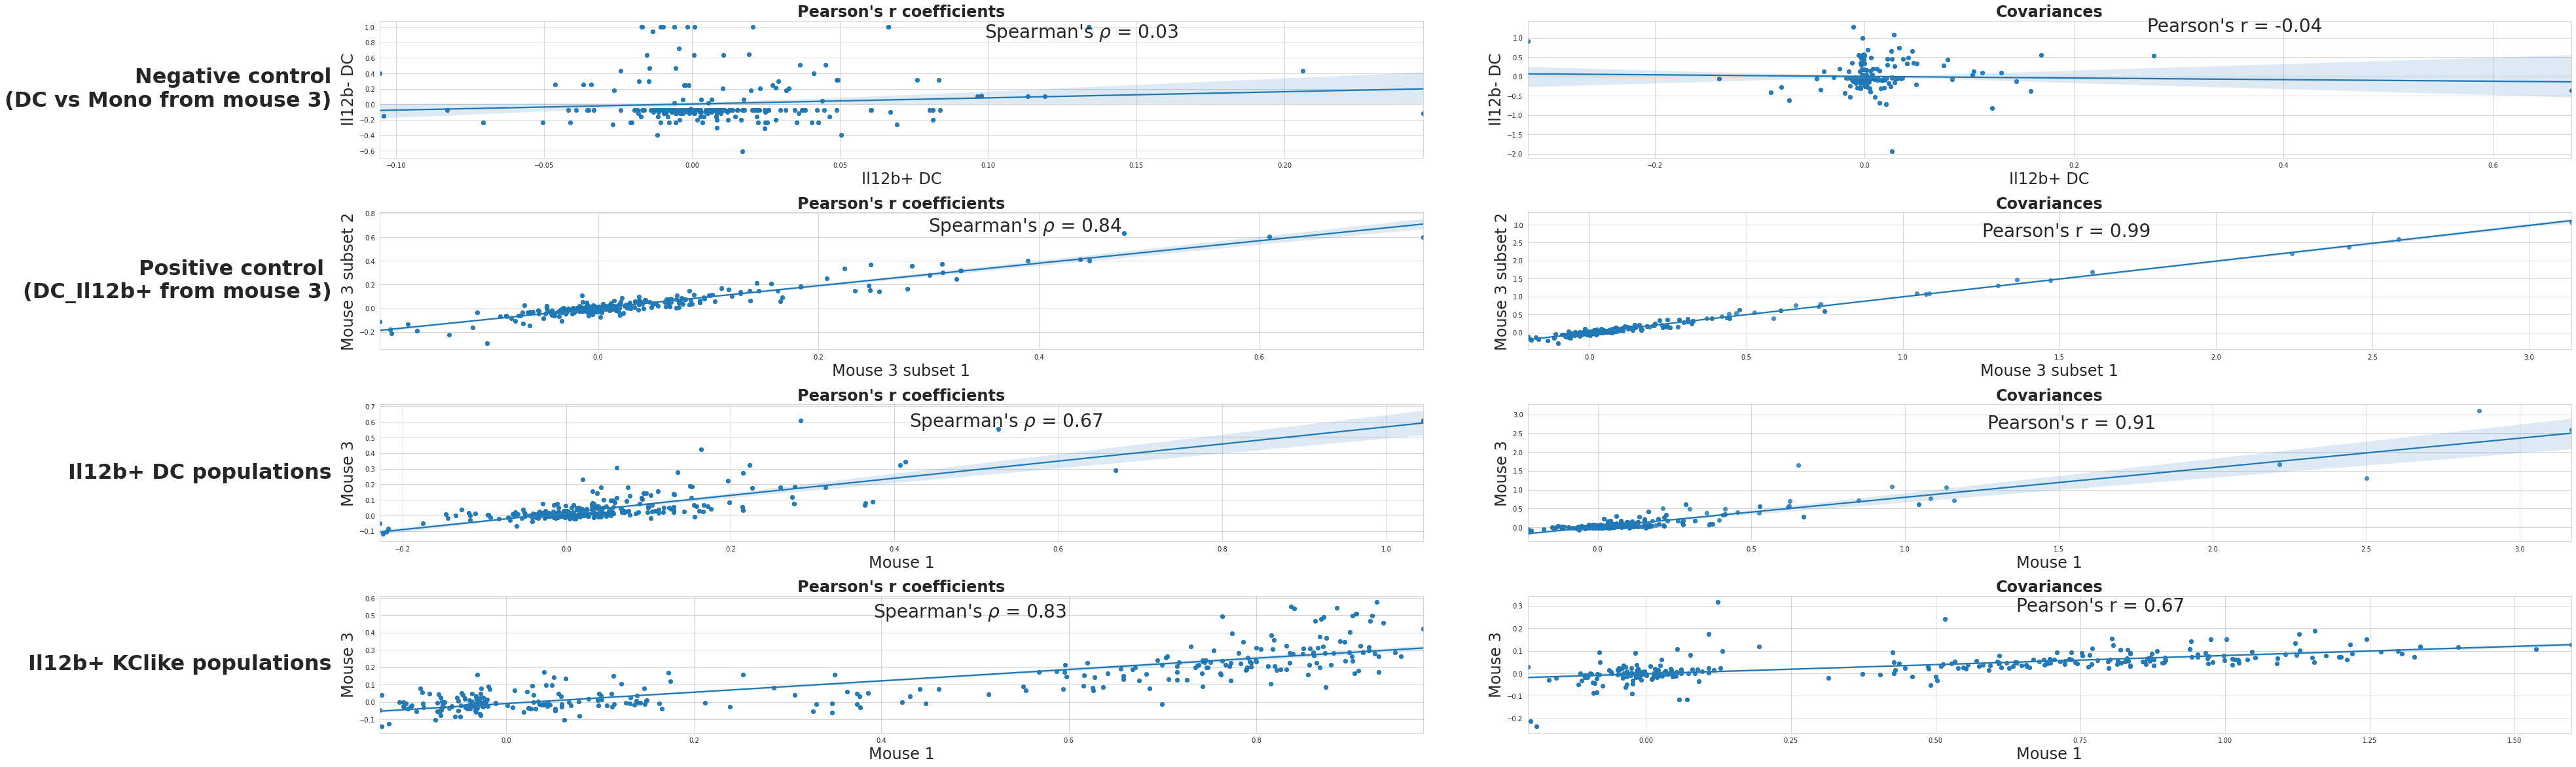

In [197]:
fig, axes = plt.subplots(4,2, figsize=(60,20))


##### NEGATIVE CONTROL #####

corr_correl = round(hvnccorr_scatter.corr(method='spearman').iloc[0,1],2)
cov_correl = round(hvnccov_scatter.corr().iloc[0,1],2)

corr_plot = sns.regplot(data=hvnccorr_scatter, x='DC', y='Mono', ax=axes[0,0], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (0.4*axes[0,0].get_xlim()[1],0.8*axes[0,0].get_ylim()[1]), fontsize=28)

cov_plot = sns.regplot(data=hvnccov_scatter, x='DC', y='Mono', ax=axes[0,1], robust=False)
cov_plot.annotate(r"Pearson's r = {}".format(cov_correl), (0.4*axes[0,1].get_xlim()[1],0.8*axes[0,1].get_ylim()[1]), fontsize=28)



#### POSITIVE CONTROL ####

corr_correl = round(hvdccorr3_scatter.corr(method='spearman').iloc[0,1],2)
cov_correl = round(hvdccov3_scatter.corr().iloc[0,1],2)

corr_plot = sns.regplot(data=hvdccorr3_scatter, x='1', y='2', ax=axes[1,0], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (0.4*axes[1,0].get_xlim()[1],0.8*axes[1,0].get_ylim()[1]), fontsize=28)

cov_plot = sns.regplot(data=hvdccov3_scatter, x='1', y='2', ax=axes[1,1], robust=False)
cov_plot.annotate(r"Pearson's r = {}".format(cov_correl), (0.4*axes[1,1].get_xlim()[1],0.8*axes[1,1].get_ylim()[1]), fontsize=28)

########### DC #########

corr_correl = round(hvdccorr_scatter.corr(method='spearman').iloc[0,1],2)
cov_correl = round(hvdccov_scatter.corr().iloc[0,1],2)

corr_plot = sns.regplot(data=hvdccorr_scatter, x='Trx1', y='Trx3', ax=axes[2,0], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (0.4*axes[2,0].get_xlim()[1],0.8*axes[2,0].get_ylim()[1]), fontsize=28)

cov_plot = sns.regplot(data=hvdccov_scatter, x='Trx1', y='Trx3', ax=axes[2,1], robust=False)
cov_plot.annotate(r"Pearson's r = {}".format(cov_correl), (0.4*axes[2,1].get_xlim()[1],0.8*axes[2,1].get_ylim()[1]), fontsize=28)

######### KCLIKE ########

corr_correl = round(hvkccorr_scatter.corr(method='spearman').iloc[0,1],2)
cov_correl = round(hvkccov_scatter.corr().iloc[0,1],2)


corr_plot = sns.regplot(data=hvkccorr_scatter, x='Trx1', y='Trx3', ax=axes[3,0], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (0.4*axes[3,0].get_xlim()[1],0.8*axes[3,0].get_ylim()[1]), fontsize=28)

cov_plot = sns.regplot(data=hvkccov_scatter, x='Trx1', y='Trx3', ax=axes[3,1], robust=False)
cov_plot.annotate(r"Pearson's r = {}".format(cov_correl), (0.4*axes[3,1].get_xlim()[1],0.8*axes[3,1].get_ylim()[1]), fontsize=28)

### GENERAL ANNOTATIONS ###

for ax in axes[:,0]:
    ax.set_title("Pearson's r coefficients", fontsize=24, fontweight="bold")
for ax in axes[:,1]:
    ax.set_title("Covariances", fontsize= 24, fontweight="bold")
    
for ax in axes.ravel():
    ax.set_xlabel('Mouse 1', fontsize=24)
    ax.set_ylabel('Mouse 3', fontsize=24)

for ax in axes[0]:
    ax.set_xlabel('Il12b+ DC', fontsize=24)
    ax.set_ylabel('Il12b- DC', fontsize=24)
    
for ax in axes[1]:
    ax.set_xlabel('Mouse 3 subset 1', fontsize=24)
    ax.set_ylabel('Mouse 3 subset 2', fontsize=24)
    

for i, axrow in enumerate(axes):
    row_lbl = ['Negative control\n(DC vs Mono from mouse 3)','Positive control \n(DC_Il12b+ from mouse 3)', 'Il12b+ DC populations', 'Il12b+ KClike populations'][i]
    
    axrow[0].annotate(row_lbl, xy=(0, 0.5), xytext=(-axrow[0].yaxis.labelpad - 10, 0),
        xycoords=axrow[0].yaxis.label, textcoords='offset points',
        size=32, ha='right', va='center', fontweight="bold")


    
#plt.tight_layout()
plt.subplots_adjust(hspace = 0.4, wspace=0.1)
plt.show()

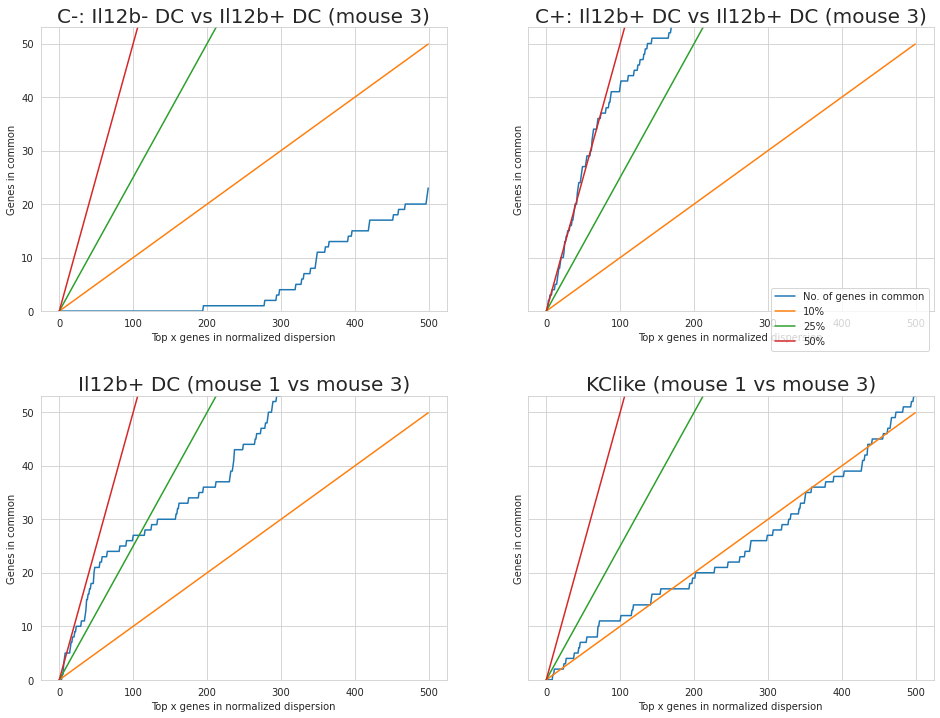

In [159]:
fig, axes = plt.subplots(2, 2, figsize=(16,12), sharey=True)

axes[0,0].plot(len_genes_in_common_nc, label='No. of genes in common')
axes[0,1].plot(len_genes_in_common_31_vs_32, label='Number of genes in common')
axes[1,0].plot(len_genes_in_common_dc, label='No. of genes in common')
axes[1,1].plot(len_genes_in_common_kc, label='No. of genes in common')


for ax in axes.ravel():
    ax.plot(0.10*np.arange(0,500,1), label='10%')
    ax.plot(0.25*np.arange(0,500,1), label='25%')
    ax.plot(0.50*np.arange(0,500,1), label='50%')
    ax.set_ylabel('Genes in common')
    ax.set_xlabel('Top x genes in normalized dispersion')
    
axes[0,0].set_ylim(0,len_genes_in_common_nc[-1])
axes[0,1].set_ylim(0,len_genes_in_common_31_vs_32[-1])
axes[1,0].set_ylim(0,len_genes_in_common_dc[-1])
axes[1,1].set_ylim(0,len_genes_in_common_kc[-1])
#axes[1].set_ylim(0,len_genes_in_common_kc[-1])

axes[0,0].set_title('C-: Il12b- DC vs Il12b+ DC (mouse 3)', fontsize=20)
axes[0,1].set_title('C+: Il12b+ DC vs Il12b+ DC (mouse 3)', fontsize=20)
axes[1,0].set_title('Il12b+ DC (mouse 1 vs mouse 3)', fontsize=20)
axes[1,1].set_title('KClike (mouse 1 vs mouse 3)', fontsize=20)

axes[1,1].legend(bbox_to_anchor=(1,1.40))

plt.subplots_adjust(hspace=0.3)
plt.show()

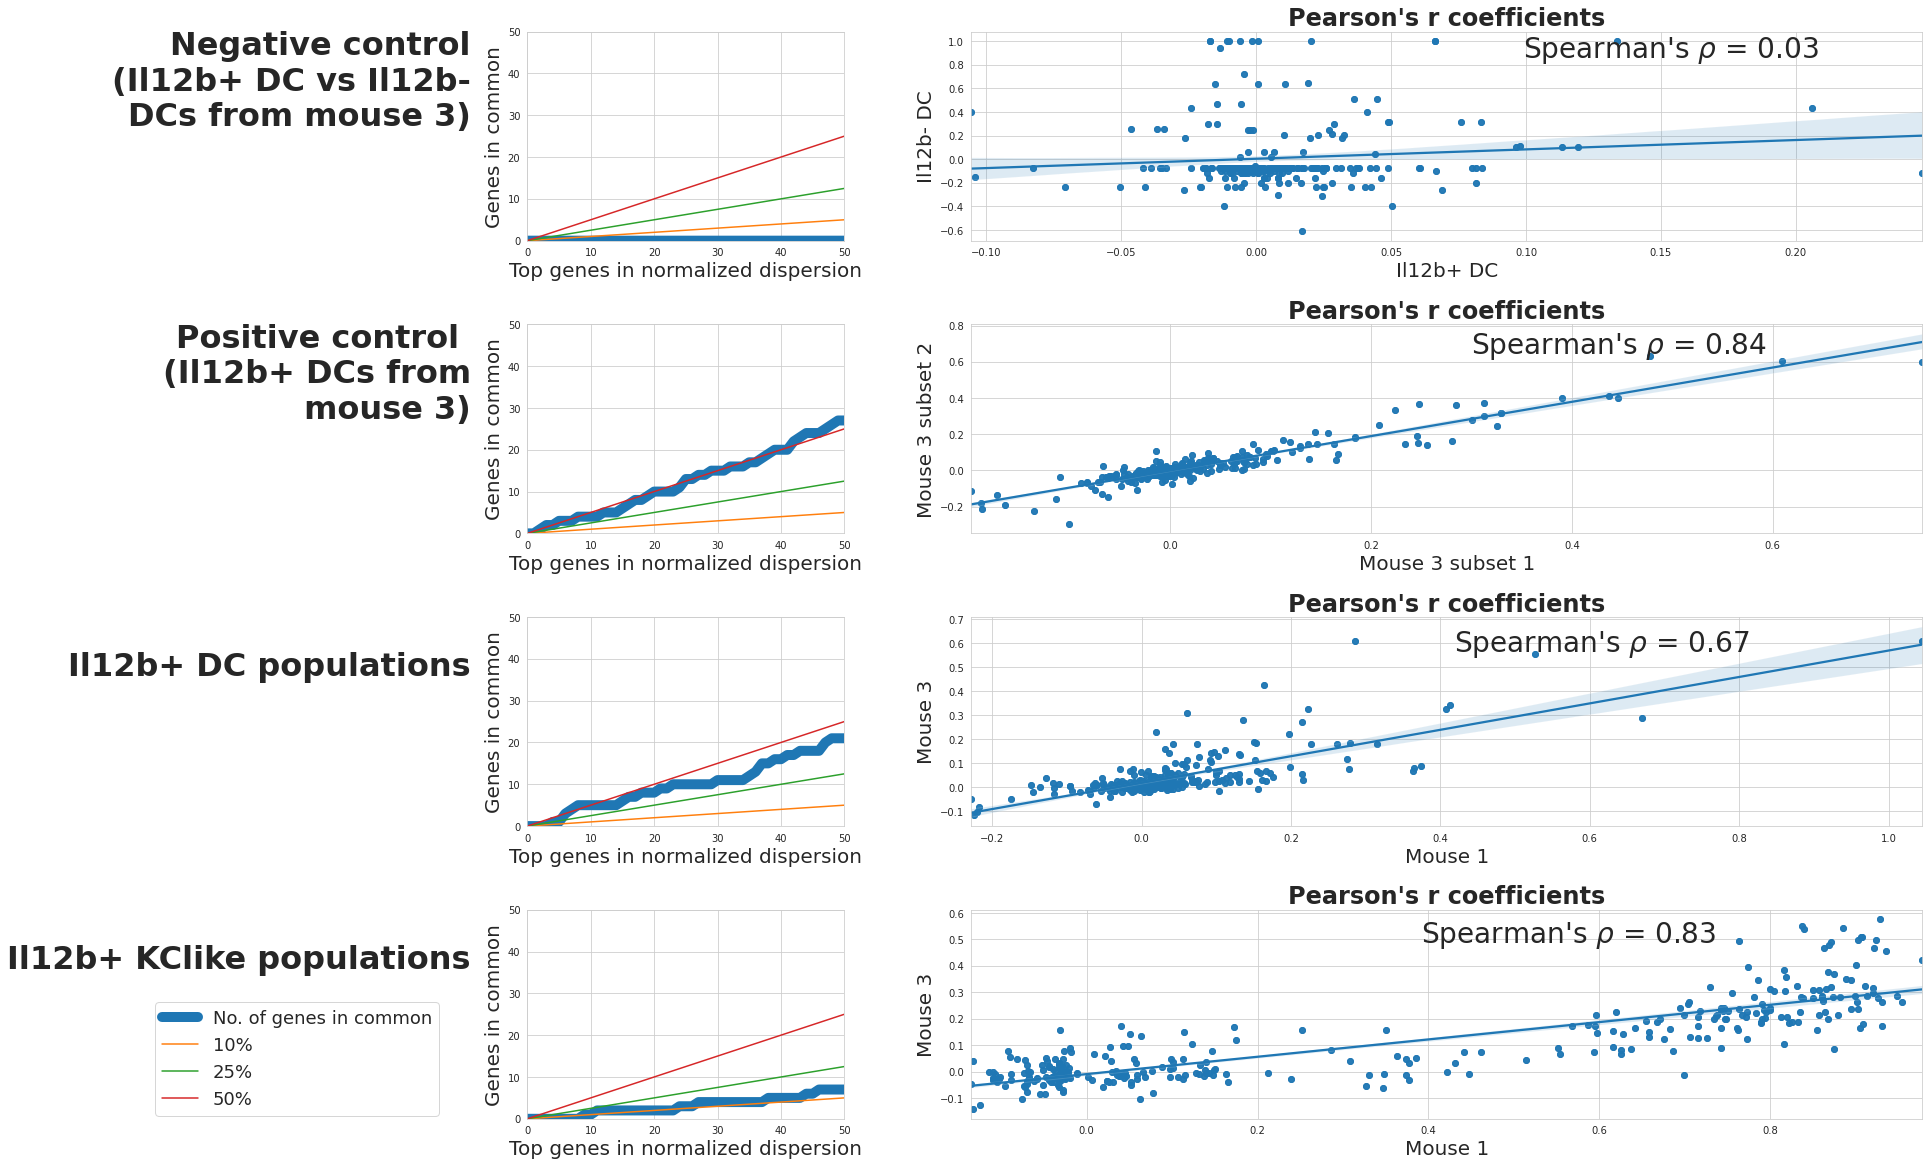

In [203]:
fig, axes = plt.subplots(4,2, figsize=(25,20), gridspec_kw={'width_ratios': [1, 3]})


##### NEGATIVE CONTROL #####

axes[0,0].plot(len_genes_in_common_nc, label='No. of genes in common', lw=10)


corr_correl = round(hvnccorr_scatter.corr(method='spearman').iloc[0,1],2)
corr_plot = sns.regplot(data=hvnccorr_scatter, x='DC', y='Mono', ax=axes[0,1], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (0.4*axes[0,1].get_xlim()[1],0.8*axes[0,1].get_ylim()[1]), fontsize=28)


#### POSITIVE CONTROL ####

axes[1,0].plot(len_genes_in_common_31_vs_32, label='Number of genes in common', lw=10)

corr_correl = round(hvdccorr3_scatter.corr(method='spearman').iloc[0,1],2)
corr_plot = sns.regplot(data=hvdccorr3_scatter, x='1', y='2', ax=axes[1,1], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (0.4*axes[1,1].get_xlim()[1],0.8*axes[1,1].get_ylim()[1]), fontsize=28)

########### DC #########

axes[2,0].plot(len_genes_in_common_dc, label='No. of genes in common', lw=10)

corr_correl = round(hvdccorr_scatter.corr(method='spearman').iloc[0,1],2)
corr_plot = sns.regplot(data=hvdccorr_scatter, x='Trx1', y='Trx3', ax=axes[2,1], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (0.4*axes[2,1].get_xlim()[1],0.8*axes[2,1].get_ylim()[1]), fontsize=28)

######### KCLIKE ########

axes[3,0].plot(len_genes_in_common_kc, label='No. of genes in common', lw=10)

corr_correl = round(hvkccorr_scatter.corr(method='spearman').iloc[0,1],2)
corr_plot = sns.regplot(data=hvkccorr_scatter, x='Trx1', y='Trx3', ax=axes[3,1], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (0.4*axes[3,1].get_xlim()[1],0.8*axes[3,1].get_ylim()[1]), fontsize=28)

### GENERAL ANNOTATIONS ###

for ax in axes[:,0]:
    ax.plot(0.10*np.arange(0,500,1), label='10%')
    ax.plot(0.25*np.arange(0,500,1), label='25%')
    ax.plot(0.50*np.arange(0,500,1), label='50%')
    ax.set_ylabel('Genes in common', fontsize=20)
    ax.set_xlabel('Top genes in normalized dispersion', fontsize=20)
    ax.set_xlim(0,50)
    ax.set_ylim(0,50)

#axes[0,0].set_ylim(0,len_genes_in_common_nc[-1])
#axes[1,0].set_ylim(0,len_genes_in_common_31_vs_32[-1])
#axes[2,0].set_ylim(0,len_genes_in_common_dc[-1])
#axes[3,0].set_ylim(0,len_genes_in_common_kc[-1])

for ax in axes[:,1]:
    ax.set_title("Pearson's r coefficients", fontsize=24, fontweight="bold")
    
for ax in [axes[2,1], axes[3,1]]:
    ax.set_xlabel('Mouse 1', fontsize=20)
    ax.set_ylabel('Mouse 3', fontsize=20)

axes[0,1].set_xlabel('Il12b+ DC', fontsize=20)
axes[0,1].set_ylabel('Il12b- DC', fontsize=20)
    
axes[1,1].set_xlabel('Mouse 3 subset 1', fontsize=20)
axes[1,1].set_ylabel('Mouse 3 subset 2', fontsize=20)
    

for i, axrow in enumerate(axes):
    row_lbl = ['Negative control\n(Il12b+ DC vs Il12b-\nDCs from mouse 3)','Positive control \n(Il12b+ DCs from\n mouse 3)', 'Il12b+ DC populations', 'Il12b+ KClike populations'][i]
    
    axrow[0].annotate(row_lbl, xy=(0, 0.8), xytext=(-axrow[0].yaxis.labelpad - 10, 0),
        xycoords=axrow[0].yaxis.label, textcoords='offset points',
        size=32, ha='right', va='center', fontweight="bold")


axes[3,0].legend(bbox_to_anchor=(-.25,0.6), fontsize=18)
    
plt.subplots_adjust(hspace = 0.4, wspace=0.2)
plt.show()

mouse
variable      Wfdc21
level_1       Wfdc21
Trx1          1.5984
Trx3        0.316512
dtype: object